### Examining some longer term properties of data

In [1]:
from yfinance import download
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.base.model import GenericLikelihoodModel
from datetime import datetime
from scipy.stats import norm

In [2]:
# get the daily returns of the S&P 500 
SPX=download('^GSPC','1957-03-01').dropna()
SPX['Return'] = SPX['Adj Close'].pct_change()*100
SPX.index = pd.DatetimeIndex(SPX.index).to_period('D')
SPX.dropna(inplace=True)
SPX.loc[SPX['Volume']==0, 'Volume'] = np.nan
SPX

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
1957-03-04,44.060001,44.060001,44.060001,44.060001,44.060001,1.890000e+06,0.731595
1957-03-05,44.220001,44.220001,44.220001,44.220001,44.220001,1.860000e+06,0.363141
1957-03-06,44.230000,44.230000,44.230000,44.230000,44.230000,1.840000e+06,0.022610
1957-03-07,44.209999,44.209999,44.209999,44.209999,44.209999,1.830000e+06,-0.045219
1957-03-08,44.070000,44.070000,44.070000,44.070000,44.070000,1.630000e+06,-0.316669
...,...,...,...,...,...,...,...
2022-07-18,3883.790039,3902.439941,3818.629883,3830.850098,3830.850098,3.414470e+09,-0.836357
2022-07-19,3860.729980,3939.810059,3860.729980,3936.689941,3936.689941,3.160350e+09,2.762829
2022-07-20,3935.320068,3974.129883,3922.030029,3959.899902,3959.899902,3.452150e+09,0.589581


In [11]:
# get annual series of proportion of year in recession
from pandas_datareader.data import DataReader
USREC=DataReader("USREC","fred",SPX.index[0].to_timestamp(),SPX.index[-1].to_timestamp()).rename(columns={"USREC":"Recession"})
USREC.index=pd.DatetimeIndex(USREC.index).to_period("D")
USREC["year"]=list(map(lambda x:x.year,USREC.index))
USREC=USREC.groupby("year").mean()
USREC

,Recession
year,
1957,0.444444
1958,0.333333
1959,0.000000
1960,0.666667
1961,0.166667
...,...
2018,0.000000
2019,0.000000
2020,0.166667


In [4]:
!pip3 install pandas-datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 KB 1.8 MB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [9]:
from arch.univariate import ARX, GARCH, GeneralizedError
from tqdm.notebook import tqdm
results=pd.DataFrame({"year":[],"mu":[],"phi":[],"C":[],"A":[],"B":[],"kappa":[]}).set_index("year")
results.index=pd.DatetimeIndex(results.index).to_period('Y')

for year in tqdm(range(SPX.index[0].year,SPX.index[-1].year+1)):
    model = ARX(SPX.loc[SPX.index.year==year,"Return"],lags=[1])
    model.volatility = GARCH(1, 0, 1)
    model.distribution = GeneralizedError()
    fit=model.fit(update_freq=0,disp='off')

    if not fit.convergence_flag:
        mu,phi,C,A,B,nu=tuple(fit.params)
        results=results.append(pd.DataFrame({"year":[year],"mu":[mu],"phi":[phi],"C":[C],"A":[A],"B":[B],"kappa":[nu/2]}).set_index("year"))

results

  0%|          | 0/66 [00:00<?, ?it/s]

/tmp/ipykernel_58/2464044170.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(pd.DataFrame({"year":[year],"mu":[mu],"phi":[phi],"C":[C],"A":[A],"B":[B],"kappa":[nu/2]}).set_index("year"))
/tmp/ipykernel_58/2464044170.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(pd.DataFrame({"year":[year],"mu":[mu],"phi":[phi],"C":[C],"A":[A],"B":[B],"kappa":[nu/2]}).set_index("year"))
/tmp/ipykernel_58/2464044170.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(pd.DataFrame({"year":[year],"mu":[mu],"phi":[phi],"C":[C],"A":[A],"B":[B],"kappa":[nu/2]}).set_index("year"))
/tmp/ipykernel_58/2464044170.py:14: FutureWarning: The frame.append method is deprecated

/tmp/ipykernel_58/2464044170.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(pd.DataFrame({"year":[year],"mu":[mu],"phi":[phi],"C":[C],"A":[A],"B":[B],"kappa":[nu/2]}).set_index("year"))
/tmp/ipykernel_58/2464044170.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(pd.DataFrame({"year":[year],"mu":[mu],"phi":[phi],"C":[C],"A":[A],"B":[B],"kappa":[nu/2]}).set_index("year"))
/tmp/ipykernel_58/2464044170.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(pd.DataFrame({"year":[year],"mu":[mu],"phi":[phi],"C":[C],"A":[A],"B":[B],"kappa":[nu/2]}).set_index("year"))
/tmp/ipykernel_58/2464044170.py:14: FutureWarning: The frame.append method is deprecated

/tmp/ipykernel_58/2464044170.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(pd.DataFrame({"year":[year],"mu":[mu],"phi":[phi],"C":[C],"A":[A],"B":[B],"kappa":[nu/2]}).set_index("year"))
/tmp/ipykernel_58/2464044170.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(pd.DataFrame({"year":[year],"mu":[mu],"phi":[phi],"C":[C],"A":[A],"B":[B],"kappa":[nu/2]}).set_index("year"))
/tmp/ipykernel_58/2464044170.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results=results.append(pd.DataFrame({"year":[year],"mu":[mu],"phi":[phi],"C":[C],"A":[A],"B":[B],"kappa":[nu/2]}).set_index("year"))
/tmp/ipykernel_58/2464044170.py:14: FutureWarning: The frame.append method is deprecated

,mu,phi,C,A,B,kappa
year,,,,,,
1957,0.033941,0.117535,0.004665,0.044984,0.955016,0.568929
1958,0.110547,0.122798,0.228933,0.260967,0.000000,1.107174
1959,0.044470,0.073390,0.122792,0.124026,0.526240,0.644856
1960,0.010647,0.235856,0.032081,0.078424,0.843589,0.731110
1961,0.095099,0.067104,0.268872,0.286805,0.000000,0.517152
...,...,...,...,...,...,...
2018,0.070139,-0.025451,0.033166,0.200780,0.799220,0.584140
2019,0.134195,-0.054537,0.041216,0.217338,0.717367,0.672854
2020,0.251211,-0.217351,0.088885,0.301122,0.698878,0.632700


In [6]:
!pip3 install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 907.3/907.3 KB 4.4 MB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [7]:
!pip3 install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 KB 1.6 MB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


### GARCH(1,1) is performed independently year-by-year. The model is also augmented to include a possible autoregressive term.
## rt = mean + phi * r(t-1) + error* s.d
### Here the term phi * r(t-1) represents the expected return that is dependent on prior information and not on original information. This can be called as "ALPHA" on quantitative finance.

### When  phi > 0, we refer to this as "MOMENTUM", ie. returns tend to follow the returns of the same sign.
### When phi < 0, we  refer to this as "MEAN REVERSION", ie returns tend to follow returns of opposite sign.

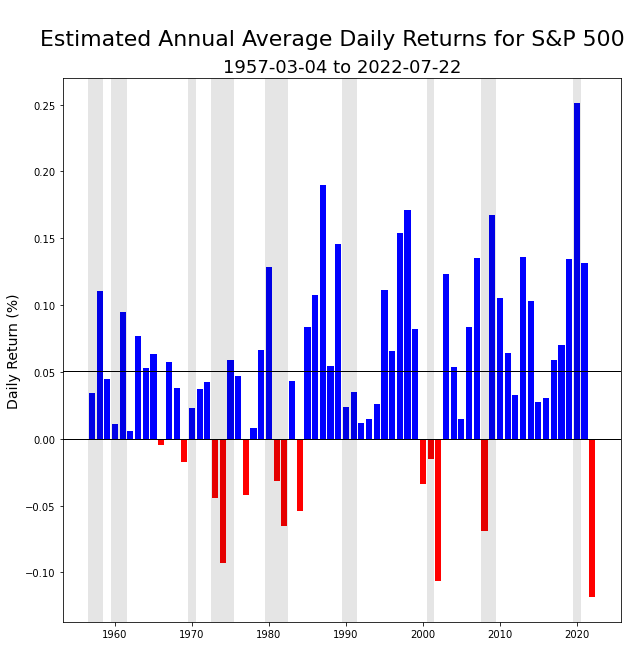

In [12]:
figure,plot=plt.subplots(figsize=(10, 10))
figure.suptitle("\nEstimated Annual Average Daily Returns for S&P 500",fontsize=22)
plot.set_title("%s to %s" % (min(SPX.index),max(SPX.index)),fontsize=18)
positive,negative=results["mu"]>0,results["mu"]<0
plot.bar(results.index[positive],results.loc[positive,"mu"],color='blue',label="$\hat\mu$")
plot.bar(results.index[negative],results.loc[negative,"mu"],color='red',label="$\hat\mu$")
plot.axhline(color='black',lw=1)

for year in [y for y in USREC.index if USREC.loc[y,"Recession"]]:
    plot.axvspan(year-(1/2),year+(1/2),facecolor="black",alpha=0.1)

plot.set_ylabel("Daily Return (%)",fontsize=14)
plot.axhline(results["mu"].mean(),color='black',lw=1);

#### The above graph shows that most of the time the market goes up. We need to examine if these different values of mean are sampling error or genuine variation.
#### One method to investigate is to use Fisher's ANOVA. But it assumes that data is normally distributed. So it cannot be applied.

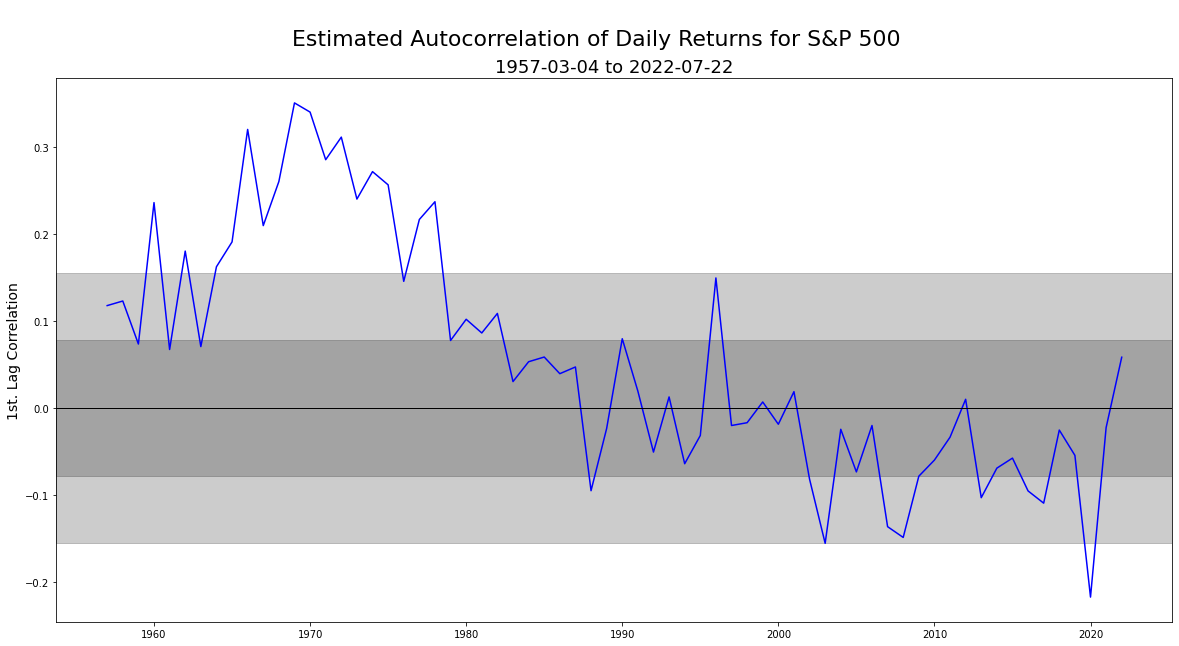

In [13]:
figure,plot=plt.subplots(figsize=(20, 10))
figure.suptitle("\nEstimated Autocorrelation of Daily Returns for S&P 500",fontsize=22)
plot.set_title("%s to %s" % (min(SPX.index),max(SPX.index)),fontsize=18)
plot.plot(results.index,results["phi"],'-',color="blue",label="$\\hat{\\phi}$")

plot.axhline(color='black',lw=1)
fisher_error=1/(np.sqrt(252)-3)
plot.axhspan(-fisher_error,fisher_error,color='black',alpha=0.2)
plot.axhspan(-2*fisher_error,2*fisher_error,color='black',alpha=0.2)
#plot.axhline(-two*fisher_error,color='black',linestyle=':',linewidth=1)
#plot.axhline(+two*fisher_error,color='black',linestyle=':',linewidth=1)

plot.set_ylabel("1st. Lag Correlation",fontsize=14);

### The above graph shows a time series of the estimated autocorrelation factor. Apart from the period in late 1960's to early 1970's the coefficient is between 95% confidence interval region defined by Fisher's estimate.
### The period in which strong positive correlation persisted corresponds to the bull market.
### The sharp -ve coefficient found half-way through 2020 is associated with the volatility around the COVID-19 pandemic

### The momentum chart shows a very important case. Anyone fitting a model to the entire period is going to measure a coefficient that is positive which might be misleading.

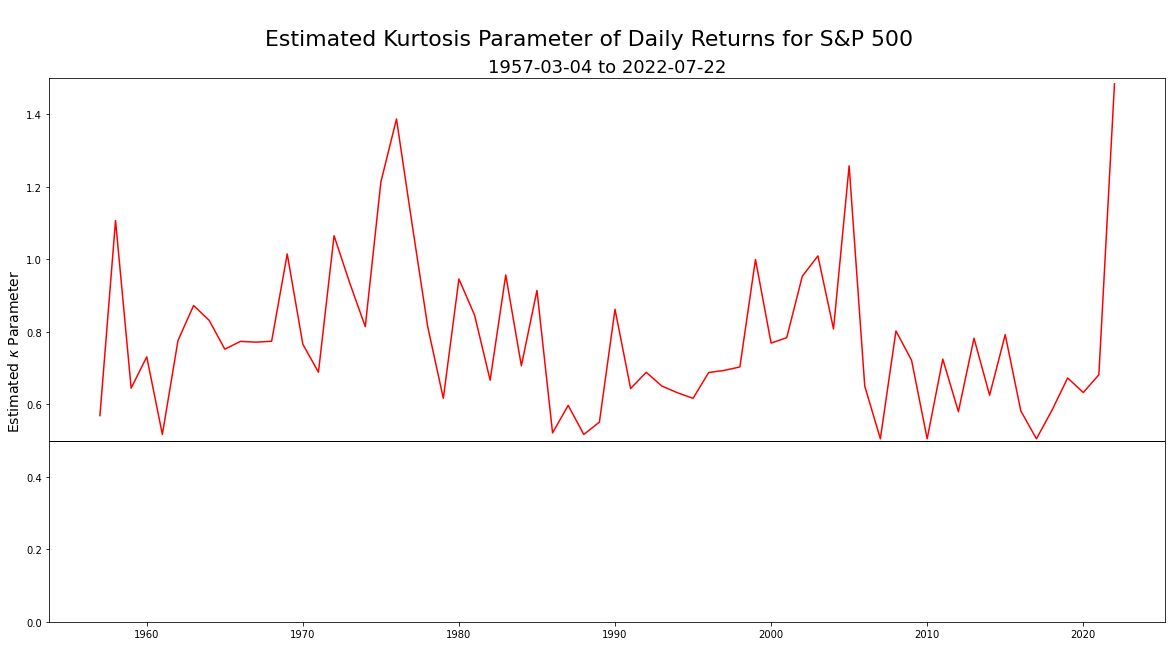

In [14]:
figure,plot=plt.subplots(figsize=(20, 10))
figure.suptitle("\nEstimated Kurtosis Parameter of Daily Returns for S&P 500",fontsize=22)
plot.set_title("%s to %s" % (min(SPX.index),max(SPX.index)),fontsize=18)
plot.plot(results.index,results["kappa"],'-',color="red",label="$\\hat{\\phi}$")

plot.axhline((1/2),color='black',lw=1)
#fisher_error=one/(np.sqrt(252)-three)
#plot.axhspan(-fisher_error,fisher_error,color='black',alpha=0.2)
#plot.axhspan(-two*fisher_error,two*fisher_error,color='black',alpha=0.2)
#plot.axhline(-two*fisher_error,color='black',linestyle=':',linewidth=1)
#plot.axhline(+two*fisher_error,color='black',linestyle=':',linewidth=1)

plot.set_ylabel("Estimated $\\kappa$ Parameter",fontsize=14)
plot.set_ylim(0,1.5);

### The above graph shows the stability of KURTOSIS as expressed through the estimated distribution parameter k. Although the estimated do move around, they are never in the region of 0.5 required to model the Normal Distribution.